In [1]:
import re
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

Using TensorFlow backend.


LOAD AND PROCESS DATA

In [2]:
df = pd.read_csv('../../datasets/complete-set.csv')
del df['Unnamed: 0']
df.dropna()

,content,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
...,...,...
33795,"For the first time in more than a decade, impo...",0
33796,Says Donald Trump has bankrupted his companies...,0
33797,"John McCain and George Bush have ""absolutely n...",0
33798,A new poll shows 62 percent support the presid...,1


In [3]:
texts = df['content']
y = pd.get_dummies(df['label'])
y = np.array(y)

DEFINING PARAMETERS

In [4]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 100 # embedding dimensions for word vectors
GLOVE_DIR = "embeddings/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [6]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 240108


In [7]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (33800, 1000)
Shape of label tensor: (33800, 2)


In [8]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [9]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('Validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [14124 12916]
Validation:  [3524 3236]


GLOVE

In [10]:
embeddings_index = {}

f = open(GLOVE_DIR, encoding='utf8')
print('Loading Glove from:', GLOVE_DIR,'…', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')

f.close()
print("Done.\n Proceeding with Embedding Matrix…", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
print("Completed!")

Loading Glove from: embeddings/glove.6B.100d.txt …Done.
 Proceeding with Embedding Matrix…Completed!


MODEL

In [16]:
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH)))
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_SEQUENCE_LENGTH, trainable=False, name = 'embeddings'))
model.add(LSTM(50, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(30, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(2, activation="sigmoid"))

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

TRAIN MODEL

In [ ]:
history = model.fit(x_train, y_train, epochs = 2, batch_size=1000, validation_data=(x_val, y_val))

Train on 27040 samples, validate on 6760 samples
Epoch 1/2
 1000/27040 [>.............................] - ETA: 7:32 - loss: 0.6921 - accuracy: 0.5260

VALIDATION

In [ ]:
model.save('../../model/GloVe6b-100-LSTM-1.h5')
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")

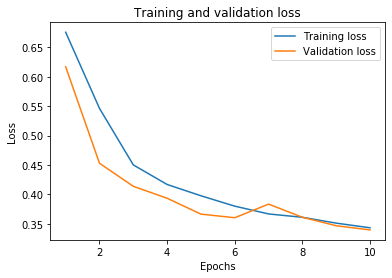

In [19]:
import matplotlib.pyplot as plt #matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

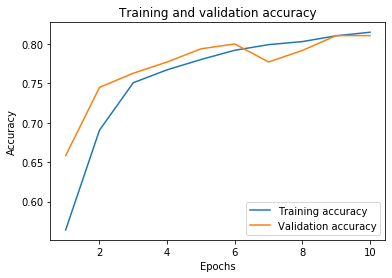

In [20]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [22]:
random_num = np.random.randint(0, 100)
test_data = texts[random_num]
test_label = y[random_num]
#clean_test_data = clean_text(test_data)
clean_test_data = test_data
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(clean_test_data)
test_sequences = tokenizer.texts_to_sequences(clean_test_data)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 1000, 100)         24010900  
_________________________________________________________________
lstm_layer (LSTM)            (None, 1000, 60)          38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [26]:
model.save_weights('./model1')

In [27]:
model.load_weights('./model1')